# Coding Task: Image Deblurring with Spectral Filters

-  implement TSVD regularization: $x_k = \sum_{i=1}^k \frac{u_i^T b}{\sigma_i} v_i$ and plot the reconstructions for different $k$.
-  implement Tikhonov regularization: $x_\delta = \sum_{i=1}^r \frac{\sigma_i}{\sigma_i^2 + \delta} (u_i^T b) v_i$ and plot the reconstructions for different  $\delta$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from skimage import color, data
from scipy.fftpack import fft2, ifft2, fftshift

In [4]:
def gaussian_kernel(size, sigma):
    """Creates a 2D Gaussian kernel."""
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    g = np.exp(-(x**2 + y**2) / (2.0 * sigma**2))
    return g / g.sum()

def get_padded_kernel_and_fft(image_shape, kernel):
    """Pads kernel and computes its FFT."""
    img_h, img_w = image_shape
    ker_h, ker_w = kernel.shape
    padded_kernel = np.zeros(image_shape)
    h_start = (img_h - ker_h) // 2
    w_start = (img_w - ker_w) // 2
    padded_kernel[h_start:h_start+ker_h, w_start:w_start+ker_w] = kernel
    return fft2(fftshift(padded_kernel))

def tikhonov_deblur(F_blurred_noisy, F_kernel, delta):
    """Performs Tikhonov deblurring in the frequency domain."""
    F_kernel_conj = np.conj(F_kernel)
    F_tikhonov = F_kernel_conj / (F_kernel_conj * F_kernel + delta)
    F_deblurred = F_blurred_noisy * F_tikhonov
    return np.real(ifft2(F_deblurred))

def tsvd_deblur(F_blurred_noisy, F_kernel, k):
    """Performs TSVD deblurring in the frequency domain."""
    F_kernel_abs = np.abs(F_kernel)
    if k >= F_kernel_abs.size or k <= 0:
        threshold = 0
    else:
        threshold = np.sort(F_kernel_abs.flatten())[-k]
    F_inv_kernel = np.conj(F_kernel) / (F_kernel_abs**2 + 1e-15)
    F_inv_kernel[F_kernel_abs < threshold] = 0
    F_deblurred = F_blurred_noisy * F_inv_kernel
    return np.real(ifft2(F_deblurred))


--- Calculating Tikhonov Deblurring ---

--- Calculating TSVD Deblurring ---

Plotting Tikhonov image grid...


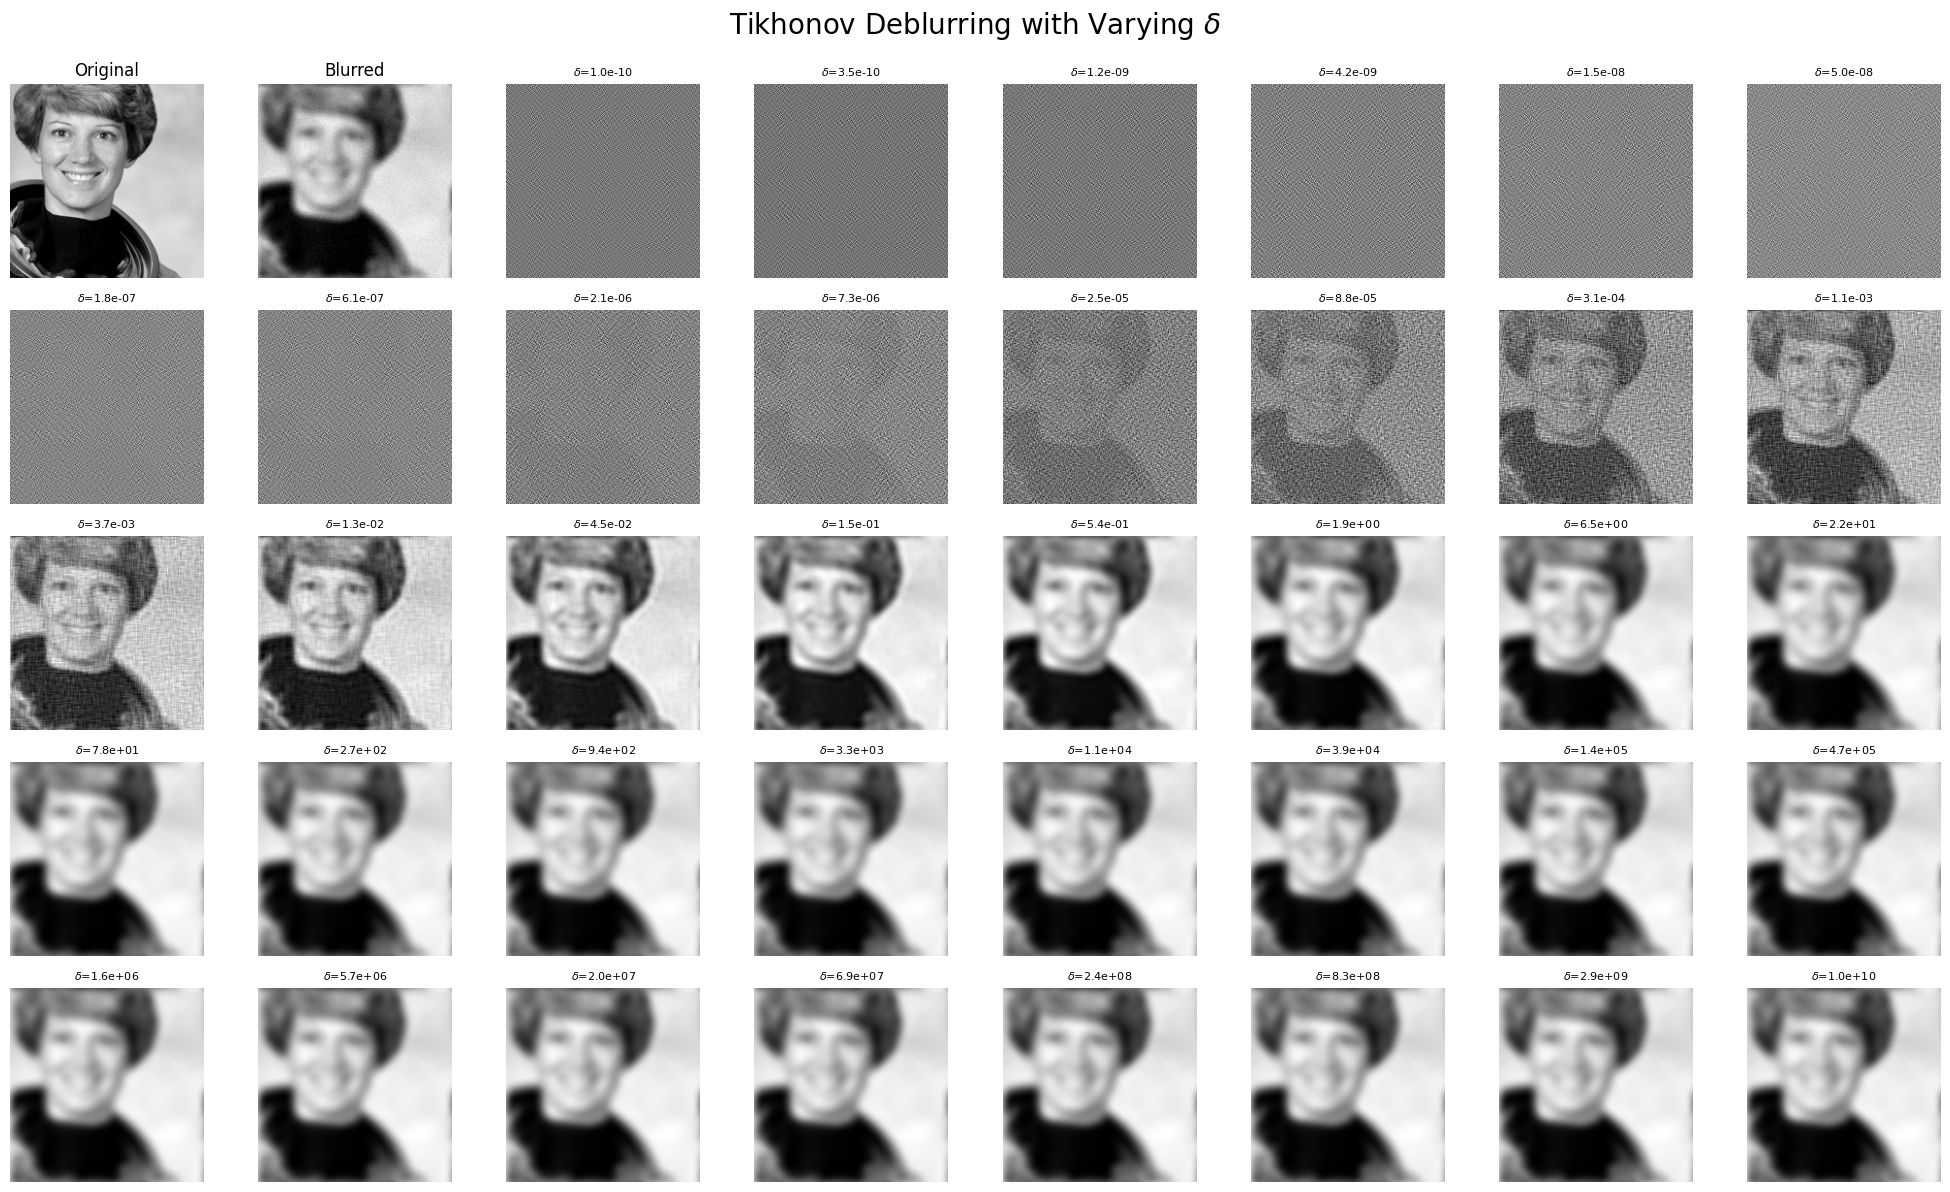


Plotting TSVD image grid...


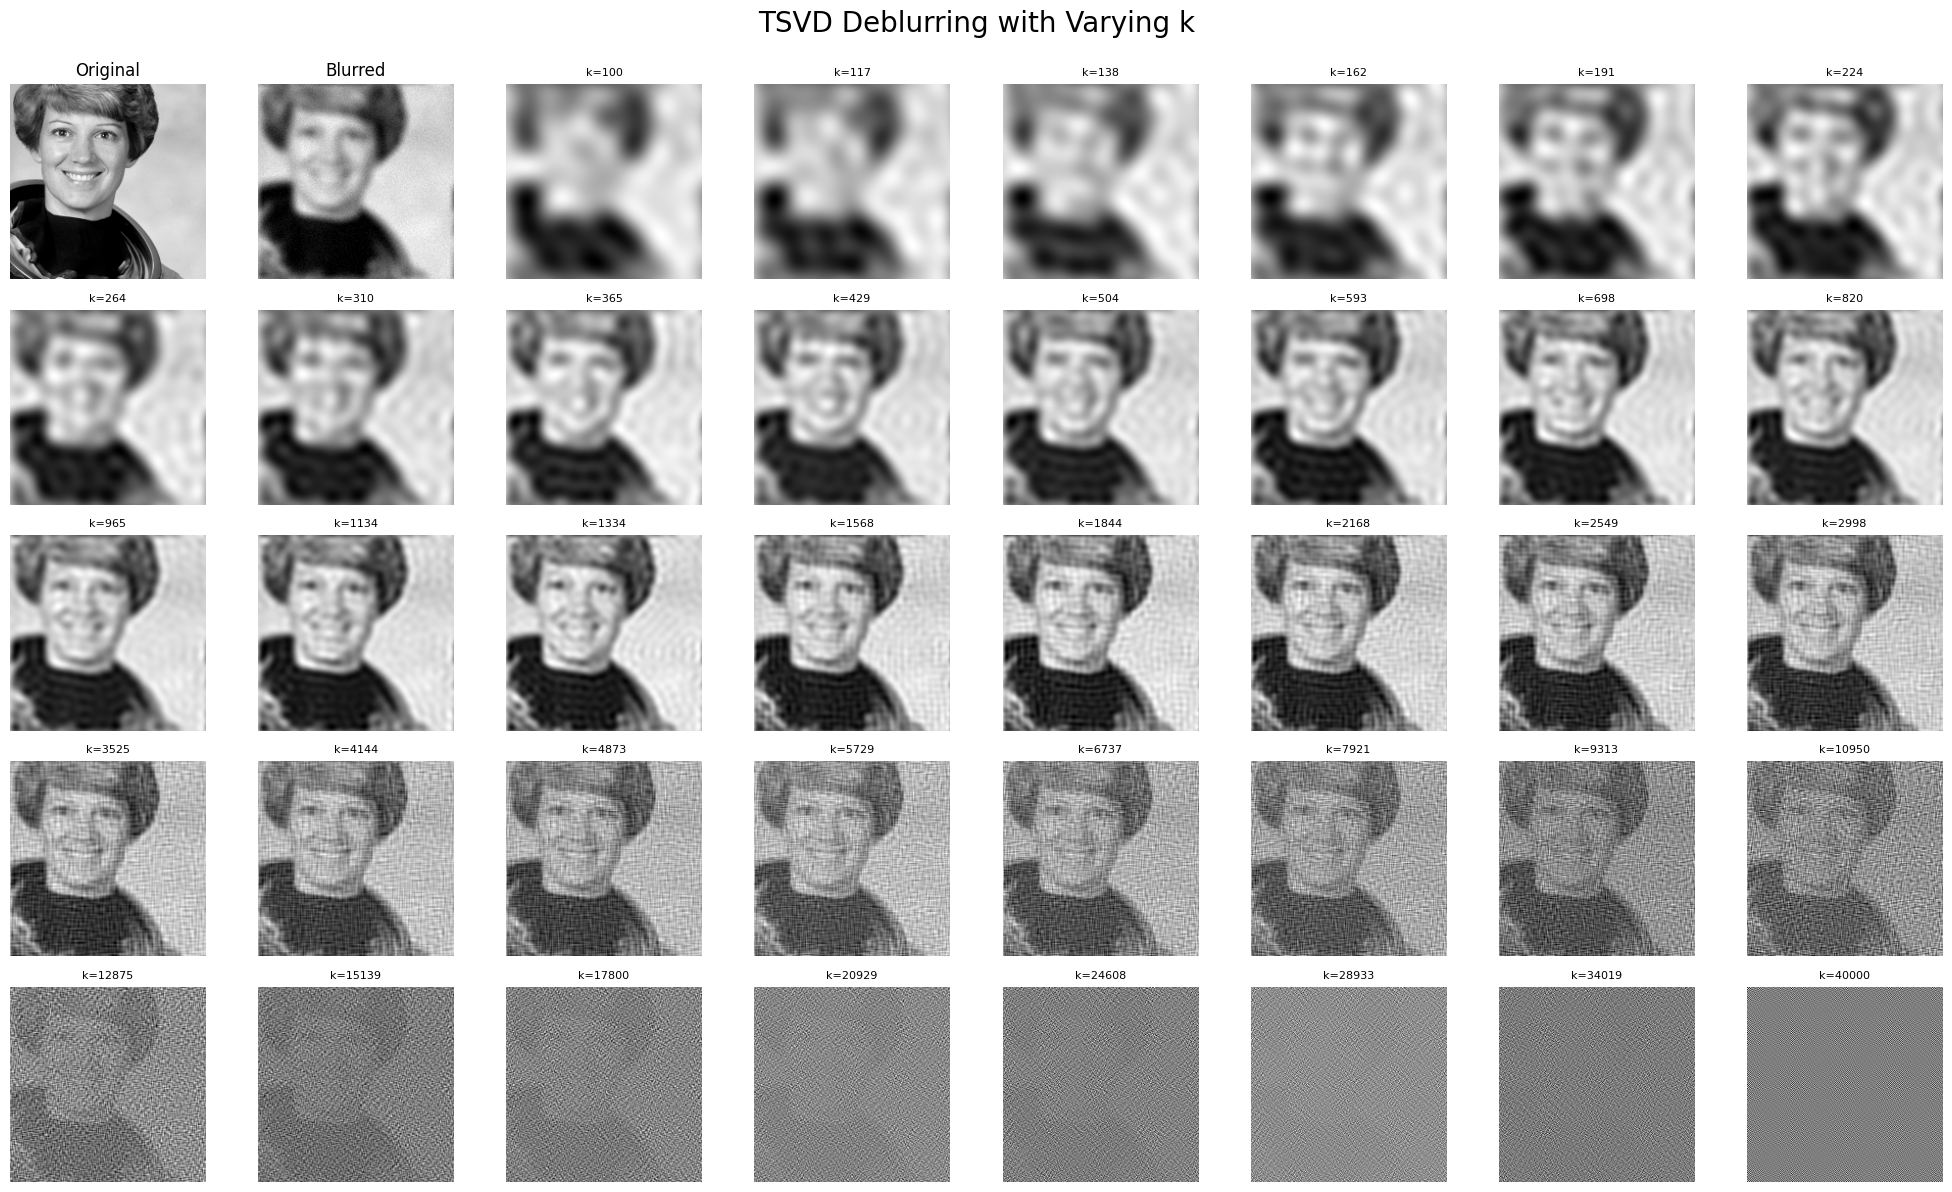


Done.


In [8]:
# 1. Load an Image
original_image = color.rgb2gray(data.astronaut())
original_image = original_image[50:250, 150:350] # Crop

# 2. Create a Blur Kernel
kernel_size = 11
kernel_sigma = 4.0
kernel = gaussian_kernel(kernel_size, kernel_sigma)

# 3. Simulate Blurring and Noise
blurred_image = convolve2d(original_image, kernel, 'same', boundary='wrap')
noise_level = 0.02
np.random.seed(42)
noisy_blurred_image = np.clip(blurred_image + noise_level * np.random.randn(*blurred_image.shape), 0, 1)

# Precompute FFTs
F_noisy_blurred = fft2(noisy_blurred_image)
F_kernel = get_padded_kernel_and_fft(original_image.shape, kernel)

# --- Tikhonov ---
print("--- Calculating Tikhonov Deblurring ---")
delta_values = np.logspace(-10, 10, 38)
tikhonov_images = []

for dlt in delta_values:
    deblurred = tikhonov_deblur(F_noisy_blurred, F_kernel, dlt)
    tikhonov_images.append(deblurred)

# --- TSVD ---
print("\n--- Calculating TSVD Deblurring ---")
total_pixels = original_image.size
k_values = np.logspace(np.log10(100), np.log10(total_pixels), 38, dtype=int)
k_values = np.unique(k_values)
tsvd_images = []

for k in k_values:
    deblurred = tsvd_deblur(F_noisy_blurred, F_kernel, k)
    tsvd_images.append(deblurred)

# --- Plotting ---

# 1. Display Tikhonov Image Grid (5x8 Layout)
print("\nPlotting Tikhonov image grid...")
fig, axes = plt.subplots(nrows=5, ncols=8, figsize=(20, 12.5))
ax = axes.ravel()
ax[0].imshow(original_image, cmap='gray')
ax[0].set_title("Original")
ax[0].axis('off')
ax[1].imshow(noisy_blurred_image, cmap='gray')
ax[1].set_title(f"Blurred")
ax[1].axis('off')

for i, (dlt, img) in enumerate(zip(delta_values, tikhonov_images)):
    # Ensure we don't plot more than available axes
    if i + 2 < len(ax):
        ax[i+2].imshow(img, cmap='gray')
        title_str = f"$\delta$={dlt:.1e}"
        ax[i+2].set_title(title_str, fontsize=8)
        ax[i+2].axis('off')

# Hide any remaining unused axes
for j in range(i + 3, len(ax)):
    fig.delaxes(ax[j])


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle("Tikhonov Deblurring with Varying $\delta$", fontsize=20)
plt.show()

# 2. Display TSVD Image Grid (5x8 Layout)
print("\nPlotting TSVD image grid...")
fig, axes = plt.subplots(nrows=5, ncols=8, figsize=(20, 12.5))
ax = axes.ravel()
ax[0].imshow(original_image, cmap='gray')
ax[0].set_title("Original")
ax[0].axis('off')
ax[1].imshow(noisy_blurred_image, cmap='gray')
ax[1].set_title(f"Blurred")
ax[1].axis('off')

num_to_plot_tsvd = min(len(k_values), len(ax) - 2)
for i in range(num_to_plot_tsvd):
    k_val = k_values[i]
    img = tsvd_images[i]
    ax[i+2].imshow(img, cmap='gray')
    title_str = f"k={k_val}"
    ax[i+2].set_title(title_str, fontsize=8)
    ax[i+2].axis('off')

# Hide unused subplots
for j in range(num_to_plot_tsvd + 2, len(ax)):
    fig.delaxes(ax[j])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle("TSVD Deblurring with Varying k", fontsize=20)
plt.show()

print("\nDone.")